In [62]:
%reset -f 
%whos

Interactive namespace is empty.


In [41]:
#%reset
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import math as m
import scipy.io as sio
import scipy.stats as st
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore

#Save
import json
import scipy.io as sio
import h5py

#Plot
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import cv2
from PIL import Image
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
sns.set_style("ticks")

#Model
import ssm

#CCM
#from DelayEmbedding import DelayEmbedding as DE

#User
#import util
#import plotting as usrplt

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
#local rastermap

from scipy.ndimage import gaussian_filter1d
from scipy.sparse.linalg import eigsh
from scipy.stats import zscore, skew
import math
import numpy as np
import time

def swap_lines(CC0, di):
    npix = CC0.shape[0]
    irange = np.arange(npix-1)
    ri = np.arange(1,npix-di-1)
    rj = ri+di
    m0 = np.logical_and(ri[:,np.newaxis]-2<irange, rj[:,np.newaxis]+1>irange)
    m0 = np.logical_not(m0).astype('float32')
    Cost = CC0[ri-1,rj+1]- CC0[ri-1,ri] - CC0[rj,rj+1]
    Cost1 = Cost[:,np.newaxis] + CC0[np.ix_(ri,irange)] + CC0[np.ix_(rj,irange+1)] - CC0[irange, irange+1]
    Cost2 = Cost[:,np.newaxis] + CC0[np.ix_(rj,irange)] + CC0[np.ix_(ri,irange+1)] - CC0[irange, irange+1]
    Cost3 = CC0[ri-1,rj] + CC0[rj+1,ri] - CC0[ri-1,ri] - CC0[rj,rj+1]
    #Cost2 = Cost2* 0
    Cost3 = Cost3* 0
    Cost12  = np.maximum(Cost1, Cost2)
    Cost123 = np.maximum(Cost12, Cost3[:, np.newaxis]) * m0
    Cmax = np.amax(Cost123)
    imax = np.argmax(Cost123)
    x,y  = np.unravel_index(imax, Cost123.shape)
    if Cost3[x]>Cost12[x,y]:
        flip = 2
    else:
        flip = Cost1[x,y] < Cost2[x,y]
    return Cmax, ri[x], irange[y], flip

def bin(X0, dt):
    NN, NT = X0.shape
    NN = int(dt * np.floor(NN/dt))
    X0 = X0[:NN, :]
    X0 = np.reshape(X0, (-1, dt, NT)).mean(axis=1)
    return X0

def resort_X(X0, niter=500):
    X = X0.copy()
    npix, nd = X.shape
    X = np.vstack((X[0,:], X, X[0,:]))
    npix, nd = X.shape
    CC = np.corrcoef(X)
    CC[0, :] = 0
    CC[-1, :] = 0
    CC[:, 0] = 0
    CC[:, -1] = 0
    xid = np.arange(npix)
    for k in range(niter):
        flag = 0
        for di in np.arange(1, npix-2):
            Cmax, xstart, xinsrt, flip  = swap_lines(CC, di)
            if Cmax>0:
                # do the swap if it improves cost
                iall = np.hstack((np.arange(xstart), np.arange(xstart+di+1,npix)))
                if xstart+di+1>=npix:
                    print(xstart, di)
                ifind = int(np.nonzero(iall==xinsrt)[0])
                if ifind+1>=len(iall):
                    print(xstart, di, ifind, len(iall))
                if flip==2:
                    isort = np.hstack((np.arange(xstart), np.arange(xstart, xstart+di+1)[::-1], np.arange(xstart+di+1,npix)))
                elif flip==1:
                    isort = np.hstack((iall[:ifind+1], np.arange(xstart, xstart+di+1)[::-1], iall[ifind+1:]))
                else:
                    isort = np.hstack((iall[:ifind+1], np.arange(xstart, xstart+di+1), iall[ifind+1:]))
                CC = CC[np.ix_(isort, isort)]
                X = X[isort, :]
                #xid1 = np.zeros(npix, 'int32')
                #xid1[isort] = xid
                xid = xid[isort]
                flag = 1
                break
        if flag==0:
            break
    print(k, flag)
    X = X[1:-1, :]
    xid = xid[1:-1] - 1
    return X, xid

def distances(x, y):
    # x and y are n_components by number of data points
    ds = np.zeros((x.shape[0], y.shape[0]))
    if len(x.shape)==1:
        x = np.reshape(x, (-1, 1))
        y = np.reshape(y, (-1, 1))
    for j in range(x.shape[1]):
        ds += dwrap(x[:,j][:,np.newaxis] - y[:,j], 1.)**2
    ds = np.sqrt(ds)
    return ds

def create_ND_basis(dims, nclust, K, flag=True):
    # recursively call this function until we fill out S
    #flag = True
    if dims==1:
        xs = np.arange(0,nclust)
        S = np.ones((K, nclust), 'float32')
        for k in range(K):
            if flag:
                S[k, :] = np.sin(math.pi + (k+1)%2 * math.pi/2 + 2*math.pi/nclust * (xs+0.5) * int((1+k)/2))
            else:
                S[k, :] = np.cos(math.pi/nclust * (xs+0.5) * k)
        S /= np.sum(S**2, axis = 1)[:, np.newaxis]**.5
        fxx = np.floor((np.arange(K)+1)/2).astype('int')
        #fxx = np.arange(K).astype('int')
    else:
        S0, fy = create_ND_basis(dims-1, nclust, K, flag)
        Kx, fx = create_ND_basis(1, nclust, K, flag)
        S = np.zeros((S0.shape[0], K, S0.shape[1], nclust), np.float64)
        fxx = np.zeros((S0.shape[0], K))
        for kx in range(K):
            for ky in range(S0.shape[0]):
                S[ky,kx,:,:] = np.outer(S0[ky, :], Kx[kx, :])
                # fxx[ky,kx] = fy[ky] + fx[kx]
                fxx[ky,kx] = max(fy[ky], fx[kx]) + min(fy[ky], fx[kx])/1000.
        S = np.reshape(S, (K*S0.shape[0], nclust*S0.shape[1]))
    fxx = fxx.flatten()
    ix = np.argsort(fxx)
    S = S[ix, :]
    fxx = fxx[ix]
    return S, fxx

def svdecon(X, k=100):
    NN, NT = X.shape
    if NN>NT:
        COV = (X.T @ X)/NT
    else:
        COV = (X @ X.T)/NN
    if k==0:
        k = np.minimum(COV.shape) - 1
    Sv, U = eigsh(COV, k = k)
    U, Sv = np.real(U), np.abs(Sv)
    U, Sv = U[:, ::-1], Sv[::-1]**.5
    if NN>NT:
        V = U
        U = X @ V
        U = U/(U**2).sum(axis=0)**.5
    else:
        V = (U.T @ X).T
        V = V/(V**2).sum(axis=0)**.5
    return U, Sv, V

def upsample(cmap, dims, nclust, upsamp):
    N = cmap.shape[0]
    # first we need the coordinates of the maximum as an array
    nup = 5
    if dims>3:
        nup = 3
    if dims>4:
        upsamp = 4
    if dims>6:
        upsamp = 2
    Km, M1, M0 = upsampled_kernel(nup, 1.0, upsamp, dims)
    xid = np.argmax(cmap, axis=1)
    iun = nclust * np.ones(dims, 'int')
    iclust = np.unravel_index(xid, iun)
    iclust = np.array(iclust)
    ipick = np.zeros((dims, N, M0.shape[1]))
    for j in range(dims):
        ipick[j] = (iclust[j][:, np.newaxis] + M0[j]) % nclust
    xid = np.ravel_multi_index(ipick.astype('int'), iun)
    iN = np.tile(np.arange(N)[:, np.newaxis], (1, M0.shape[1]))
    C0 = cmap[iN.astype('int'), xid]
    mu = np.mean(C0, axis=1)
    C0 = C0 - mu[:, np.newaxis]
    upC = C0 @ Km.T
    xid = np.argmax(upC, axis=1)
    cmax = np.amax(upC, axis=1) + mu
    dxs = M1[:, xid]
    xs = (iclust + dxs)/nclust
    xs = xs%1.
    xs = xs.T
    return xs, cmax


def dwrap(kx,nc):
    '''compute a wrapped distance'''
    q1 = np.mod(kx, nc)
    q2 = np.minimum(q1, nc-q1)
    return q2

def my_mesh(dims, xs):
    if dims==1:
        mesh = np.reshape(xs, (1,-1))
    else:
        mesh = my_mesh(dims-1, xs)
        m0 = xs[:, np.newaxis] * np.ones(mesh.shape[1])
        m0 = np.reshape(m0, (1, -1))
        mesh = np.tile(mesh, (1, len(xs)))
        mesh = np.concatenate((mesh, m0), axis = 0)
    return mesh

def upsampled_kernel(nclust, sig, upsamp, dims):
    # assume the input is 5 by 5 by 5 by 5.... vectorized

    r = int((nclust-1)/2)
    xs = np.linspace(-r,r,nclust)
    xn = np.linspace(-r,r,(nclust-1)*upsamp+1)
    M0 = my_mesh(dims, xs)
    M1 = my_mesh(dims, xn)

    d1 = np.zeros((M1.shape[1], M0.shape[1]))
    d0 = np.zeros((M0.shape[1], M0.shape[1]))
    for j in range(M0.shape[0]):
        d1 += (M1[j,:][:,np.newaxis] - M0[j,:])**2
        d0 += (M0[j,:][:,np.newaxis] - M0[j,:])**2
    K0 = np.exp(-d0/sig**2)
    K1 = np.exp(-d1/sig**2)
    Km = K1 @ np.linalg.inv(K0 + .01 * np.eye(K0.shape[0]))

    return Km, M1, M0

class Rastermap:
    """Rastermap embedding algorithm
    Rastermap takes the nPCs (400 default) of the data, and embeds them into
    n_X clusters. It returns upsampled cluster identities (n_X*upsamp).
    Optionally, a 1D embeddding is also computed across the second dimension (n_Y>0),
    smoothed over, and the PCA recomputed before fitting Rastermap.
    data X: n_samples x n_features
    Parameters
    -----------
    n_components : int, optional (default: 2)
        dimension of the embedding space
    alpha : float, optional (default: 1.0)
        exponent of the power law enforced on component n as: 1/(K+n)^alpha
    K :  float, optional (default: 1.0)
        additive offset of the power law enforced on component n as: 1/(K+n)^alpha
    n_X :  int, optional (default: 40)
        size of the grid on which the Fourier modes are rasterized
    n_Y : int, optional (default: 0, i.e. not used)
        number of Fourier components in Y: will be used to smooth data for better PCs
    nPC : int, optional (default: 400)
        number of PCs to use during optimization
    init : initialization of algorithm (default: 'pca')
        can use 'pca', 'random', or a matrix n_samples x n_components
    verbose: bool (default: True)
        whether to output progress during optimization
    """
    def __init__(self, n_components=2, n_X = 40,
                 nPC = 200, init='pca', alpha = 1., K = 1.,
                 mode = 'basic', verbose = True, annealing = True, constraints = 2):

        self.n_components = n_components
        self.alpha = alpha
        self.K     = K
        self.nPC = nPC
        self.init = init
        self.mode = mode
        self.constraints = constraints
        self.annealing = annealing
        self.n_X  = int(n_X)
        self.verbose = verbose

    def fit(self, X=None, u=None, sv=None, v=None):
        """Fit X into an embedded space.
        Inputs
        ----------
        X : array, shape (n_samples, n_features)
        u,s,v : svd decomposition of X (optional)
        Assigns
        ----------
        embedding : array-like, shape (n_samples, n_components)
            Stores the embedding vectors.
        u,sv,v : singular value decomposition of data S, potentially with smoothing
        isort1 : sorting along first dimension of matrix
        isort2 : sorting along second dimension of matrix (if n_Y > 0)
        cmap: correlation of each item with all locations in the embedding map (before upsampling)
        A:    PC coefficients of each Fourier mode
        """
        if self.mode is 'parallel':
            Xall = X.copy()
            X = np.reshape(Xall.copy(), (-1, Xall.shape[-1]))
        #X -= X.mean(axis=-1)[:,np.newaxis]
        if ((u is None)):
            # compute svd and keep iPC's of data
            nmin = min([X.shape[0], X.shape[1]])
            nmin = np.minimum(nmin-1, self.nPC)
            u,sv,v = svdecon(np.float64(X), k=nmin)
            u = u * sv

        NN, self.nPC = u.shape
        if self.constraints==3:
            plaw = 1/(1+np.arange(1000))**(self.alpha/2)
            self.vscale = np.sum(u**2,axis=0)**.5
            tail = self.vscale[-1] * plaw[u.shape[1]:]/plaw[u.shape[1]]
            self.vscale = np.hstack((self.vscale, tail))
        # first smooth in Y (if n_Y > 0)
        self.u = u
        self.v = v
        if self.mode is 'parallel':
            NN = Xall.shape[1]
            X = np.zeros((2, NN, u.shape[1]), 'float64')
            for j in range(2):
                Xall[j] -= Xall[j].mean(axis=-1)[:, np.newaxis]
                X[j] = Xall[j] @ self.v

        if self.init == 'pca':
            usort = u * np.sign(skew(u, axis=0))
            init_sort = np.argsort(usort[:NN, :self.n_components], axis=0)
            #init_sort = u[:NN,:self.n_components]
            if False:
                ix = init_sort > 0
                iy = init_sort < 0
                init_sort[ix] = init_sort[ix] - 100.
                init_sort[iy] = init_sort[iy] + 100.
        elif self.init == 'random':
            init_sort = np.random.permutation(NN)[:,np.newaxis]
            for j in range(1,self.n_components):
                init_sort = np.concatenate((init_sort, np.random.permutation(NN)[:,np.newaxis]), axis=-1)
        else:
            init_sort = self.init
        if self.n_components==1 and init_sort.ndim==1:
            init_sort = init_sort[:,np.newaxis]

        # now sort in X
        isort1, iclustup = self._map(u.copy(), self.n_components, self.n_X, init_sort)
        self.isort = isort1
        self.embedding = iclustup
        return self

    def fit_transform(self, X, u=None, sv=None, v=None):
        """Fit X into an embedded space and return that transformed
        output.
        Inputs
        ----------
        X : array, shape (n_samples, n_features). X contains a sample per row.
        Returns
        -------
        embedding : array, shape (n_samples, n_components)
            Embedding of the training data in low-dimensional space.
        """
        self.fit(X, u, sv, v)
        return self.embedding

    def transform(self, X):
        """ if already fit, can add new points and see where they fall"""
        iclustup = []
        dims = self.n_components
        if hasattr(self, 'isort1'):
            if X.shape[1] == self.v.shape[0]:
                # reduce dimensionality of X
                X = X @ self.v
                nclust = self.n_X
                AtS = self.A.T @ self.S
                vnorm   = np.sum(self.S * (self.A @ AtS), axis=0)[np.newaxis,:]
                cv      = X @ AtS
                cmap    = np.maximum(0., cv)**2 / vnorm
                iclustup, cmax = upsample(np.sqrt(cmap), dims, nclust, 10)
            else:
                print('ERROR: new points do not have as many features as original data')
        else:
            print('ERROR: need to fit model first before you can embed new points')
        if iclustup.ndim > 1:
            iclustup = iclustup.T
        else:
            iclustup = iclustup.flatten()
        return iclustup

    def _create_2D_basis0(self, K, nclust):
        xs,ys = np.meshgrid(np.arange(nclust), np.arange(nclust))
        S = np.zeros((nclust, nclust, nclust, nclust), np.float64)
        x0 = np.arange(nclust)
        sig = 1.
        for kx in range(nclust):
            for ky in range(nclust):
                ds = dwrap(xs - x0[kx], nclust)**2 + dwrap(ys - x0[ky], nclust)**2
                S[ky, kx, :, :] = np.exp(-ds**.5/sig)
        S = np.reshape(S, (nclust**2, nclust**2))
        U, Sv, S = svdecon(S, k = K)
        S = S.T
        return S

    def _map(self, X, dims, nclust, u):
        if self.mode is 'parallel':
            Xall = X
            X = Xall[1]

        X -= X.mean(axis=0)
        NN,nPC = X.shape
        # initialize 1D clusters as nodes of 1st PC
        xid = np.zeros(NN)
        for j in range(dims):
            iclust = np.floor(nclust * u[:,j].astype(np.float64)/NN)
            xid = nclust * xid + iclust
        xid = xid.astype('int').flatten()

        if self.constraints==0:
            nfreqs = nclust
        elif self.constraints==1:
            nfreqs = np.ceil(1/4 * nclust)
            nfreqs = int(2 * np.floor(nfreqs/2)+1)
        else:
            nfreqs = np.ceil(2/3 * nclust)
            nfreqs = int(2 * np.floor(nfreqs/2)+1)

        if dims>1:
            SALL, fxx = create_ND_basis(dims, nclust, nfreqs, True)
        else:
            SALL, fxx = create_ND_basis(dims, nclust, nfreqs, False)
        SALL = SALL[1:, :]
        fxx = fxx[1:]
        tic = time.time()

        if dims==1:
            #nskip = int(max(1., 2*nfreqs/50))
            #full_pass = np.arange(1, nfreqs, nskip).astype('int')
            #full_pass = np.exp(np.linspace(np.log(1), np.log(nfreqs), 50)).astype('int')

            nskip = int(2 * max(1., nfreqs/100))
            ncomps_anneal = (np.arange(3, nfreqs, nskip)**dims).astype('int')  - 1
            ncomps_anneal = np.tile(ncomps_anneal, (2,1)).T.flatten()
            ncomps_anneal = np.concatenate((ncomps_anneal[:10], ncomps_anneal[2:10], ncomps_anneal[4:], SALL.shape[0]*np.ones(20)), axis=0).astype('int')
        else:
            nskip = int(2 * max(1., nfreqs/50))
            full_pass = (np.arange(3, nfreqs, nskip)**dims).astype('int')  - 1
            full_pass = np.tile(full_pass, (2,1)).T.flatten()

        nbasis,npix = SALL.shape
        #phase1 = full_pass[:10]
        #phase2 = full_pass[10] * np.ones(20)
        #phaseX = nbasis * np.ones(20)
        #ncomps_anneal = np.hstack((phase1, phase2, full_pass[3:], phaseX)).astype('int')

        print(ncomps_anneal.shape)

        if self.constraints==2:
            self.vscale = 1/(self.K + np.arange(len(fxx)))**(self.alpha/2)

        xnorm = (X**2).sum(axis=1)[:,np.newaxis]
        E = np.zeros(len(ncomps_anneal)+1)
        if self.verbose:
            print('time; iteration;  explained PC variance')
        if self.mode is 'parallel':
            cmapx = np.zeros((2, NN, nclust**dims), 'float32')

        #lam = 10*(1 + np.arange(SALL.shape[0]))/SALL.shape[0]
        for t,nc in enumerate(ncomps_anneal):
            # get basis functions
            S = SALL[:nc, :]
            X0 = np.zeros((npix, nPC))
            for j in range(npix):
                X0[j, :] = X[xid==j, :].sum(axis=0)

            A = S @ X0
            nA      = np.sum(A**2, axis=1)**.5
            if self.constraints<2:
                nA = np.ones(nA.shape)
            else:
                nA      /= self.vscale[:nc]
            A        /= nA[:, np.newaxis]
            eweights = ((S.T / nA) @ S)[xid, :]
            AtS     = A.T @ S
            if self.mode=='parallel':
                X = Xall[t%2]

            cv      = X @ AtS
            vnorm   = np.sum(AtS**2, axis=0)[np.newaxis,:]
            vnorm   = vnorm + xnorm  * eweights**2 - 2*eweights * cv
            cv      = cv - xnorm * eweights
            cmap    = np.maximum(0., cv)**2 / vnorm
            cmax    = np.amax(cmap, axis=1)
            xid     = np.argmax(cmap, axis=1)

            #asort   = np.argsort(xid)
            #xid[asort] = (np.arange(NN)*S.shape[1]/NN).astype('int')

            E[t]    = np.nanmean(cmax)/np.nanmean(xnorm)
            if self.mode is 'parallel':
                cmapx[t%2] = cmap
            if t%10==0:
                if self.verbose:
                    print('%2.2fs    %2.0d        %4.4f'%(time.time()-tic, t, E[t]))
        if self.verbose:
            print('%2.2fs   final      %4.4f'%(time.time()-tic, E[t]))
        if self.mode is 'parallel':
            iclustup1, cmax = upsample(np.sqrt(cmapx[0]), dims, nclust, 10)
            iclustup2, cmax = upsample(np.sqrt(cmapx[1]), dims, nclust, 10)
            iclustup = np.concatenate((iclustup1[np.newaxis, :, :], iclustup2[np.newaxis, :, :]), axis=0)
            isort = np.argsort(iclustup2[:,0])
            self.cmap = cmapx
        else:
            iclustup, cmax = upsample(np.sqrt(cmap), dims, nclust, 10)
            isort = np.argsort(iclustup[:,0])
            self.cmap = cmap
        E[t+1] = np.nanmean(cmax**2)/np.nanmean(xnorm)
        if self.verbose:
            print('%2.2fs upsampled    %4.4f'%(time.time()-tic, E[t+1]))
        self.E = E
        self.S = S
        self.A = A
        self.xid = xid
        return isort, iclustup

def main(X,ops=None,u=None,sv=None,v=None):
    if u is None:
        nmin = min([X.shape[0],X.shape[1]])
        nmin = np.minimum(nmin-1, ops['nPC'])
        sv,u = eigsh(X @ X.T, k=nmin)
        sv = sv**0.5
        v = X.T @ u
    isort2,iclust2 = _map(X.T,ops,v,sv)
    Xm = X - X.mean(axis=1)[:,np.newaxis]
    Xm = gaussian_filter1d(Xm,3,axis=1)
    isort1,iclust1 = _map(Xm,ops,u,sv)
    return isort1,isort2

In [43]:
def calculate_meso_dfof(fluorescence, baseline = 15,window = 100):
    #Get sizes
    nROIs, nBins = fluorescence.shape

    if window == None:
        #Calculate baseline fluorescence 
        if baseline == 'mean':
            F = np.mean(fluorescence,axis=1).reshape(-1,1)
        else:
            F = np.percentile(fluorescence, baseline, axis=1).reshape(-1,1)
        
       #Calculate dfof 
        dfof = np.divide(fluorescence - F, F, out = np.zeros((nROIs, nBins),dtype=np.float32),where = F!=0)
    else:
        dfof = np.zeros((nROIs, nBins),dtype=np.float32)
        for t in range(nBins):
            if t < window:
                if baseline == 'mean':
                    F = np.mean(fluorescence[:,slice(0,t+window)],axis=1)
                else:
                    F = np.percentile(fluorescence[:,slice(0,t+window)],baseline,axis=1)
            else:
                if baseline == 'mean':
                    F = np.mean(fluorescence[:,slice(t-window,t+window)],axis=1)
                else:
                    F = np.percentile(fluorescence[:,slice(t-window,t+window)],baseline,axis=1)
            
#             F = F.reshape(-1,1)
            dfof[:,t] = np.divide(fluorescence[:,t] - F, F, out = np.zeros((nROIs,),dtype=np.float32),where = F!=0)
            
    return dfof

In [48]:
#load npy files: standard frames, nb_dump, nwb, arrays, rastermap
import numpy as np

#Unpack dictionary into individual variables with same individual names as in previous session
from operator import itemgetter

def getList(dict):
    list = []
    for key in dict.keys():
        list.append(key)
          
    return list

npy_dict_name=input("Enter full path and filename of .npy file to load")
npy_dict=np.load(npy_dict_name,allow_pickle='True')
npy_dict=npy_dict.item()

npy_dict_list=getList(npy_dict)
print(npy_dict_list)
print(len(npy_dict_list))

for i in range(0,len(npy_dict_list)):
    globals()[npy_dict_list[i]]=itemgetter(npy_dict_list[i])(npy_dict)

#%whos

Enter full path and filename of .npy file to load G:\uobrainflex_analysis_2022\3056_200924_E235_1_00003_00001\rastermap_3056_200924_E235_1_00003_00001_20220823-094327.npy


['y_pred', 'isort_dfof', 'isort_dfof_raw', 'isort', 'isort_dfof_pca1', 'plotslice', 'isort_dfof_kmeans', 'nClusters', 'nClusters_PC1', 'min_range', 'max_range', 'min_range_PC1', 'max_range_PC1', 'areas_rastermap_density', 'areas_rastermap_density_PC1', 'raster_cell_count', 'raster_cell_count_PC1', 'raster_cell_densities', 'raster_cell_densities_PC1', 'session_masks_rastermap_density', 'session_masks_rastermap_density_PC1', 'im_restrict_masked_rastermap_density', 'im_restrict_masked_rastermap_density_PC1', 'kernel_size', 'kernel', 'raster_mean_traces', 'raster_mean_traces_PC1', 'raster_mean_traces_convolved', 'raster_mean_traces_convolved_PC1', 'isort_rastergroup', 'isort_rastergroup_PC1', 'nClust_cell_count', 'nClust_cell_count_PC1', 'plot_time', 'model_dfof', 'model_dfof_raw', 'model_dfof_pca1']
37


In [49]:
PlotDir='G:\\uobrainflex_analysis_2022\\A1V1M2\\standard_frames_plus_kMOSEQ_15_perc'
fsuffix='3056_200924_E235_1_00003_00001'
save_folder=PlotDir

In [50]:
#Recalculate dfof with 15th percentile baselines

#Get fluorescence for ROIs we strongly believe to be cells
iscell_bool = (iscell[:,0] == 1) & (iscell[:,1] > 0.50)

if spks.shape[1]<meso_t.shape[0]:
    trunc=True
    meso_t=meso_t.copy()[:spks.shape[1]]
    
fluorescence = F[iscell_bool]
neuropil = Fneu[iscell_bool]
events = spks[iscell_bool]
events_binary = events > 0
stat_sub = [stat[i] for i in range(nROIs) if iscell_bool[i]]
spks_z = zscore(spks,axis=1)
spks_z = spks_z[iscell_bool]

if meso_t.shape[0]<spks.shape[1]:
    rev_trunc=True
    fluorescence=fluorescence.copy()[:,:len(meso_t)]
    neuropil=neuropil.copy()[:,:len(meso_t)]
    events=events.copy()[:,:len(meso_t)]
    spks=spks.copy()[:,:len(meso_t)]

#Neuropil subtraction
F_sub = fluorescence - 0.7*neuropil

for i in range(0,len(F_sub)):
    F_sub[i] = F_sub[i]-np.min(F_sub[i])

#Calclate dfof based on a mean baseline fluorescence
dfof = calculate_meso_dfof(F_sub,15,window=100)
#if trunc==True:
#    dfof=dfof.copy()[:spks.shape[1]]
    
nNeurons, T = dfof.shape

#create dfof pd.Series
dfof_trans=np.transpose(dfof.copy())
dfof_trans_frame=pd.DataFrame(dfof_trans.copy(),index=meso_t)
dfof_frame=np.transpose(dfof_trans_frame.copy())

#Z-score dfof
dfof_z = zscore(dfof,axis=1)
N, T = dfof_z.shape

#create dfof_z pd.Series
dfof_z_trans=np.transpose(dfof_z.copy())
dfof_z_trans_frame=pd.DataFrame(dfof_z_trans.copy(),index=meso_t)
dfof_z_frame=np.transpose(dfof_z_trans_frame.copy())

In [51]:
ppl_cam_rate=30
sound_rate=50000

import scipy.signal
    
#downsample or upsample behav variables to resamp rate (usually 10 Hz) from brate (usually 5000 Hz)
dwn_samp=int(brate/resamp_rate)
ppl_dwn_samp=int(ppl_cam_rate/resamp_rate)
sound_dwn_samp=int(sound_rate/resamp_rate)

behav_ser_dict_resamp=behav_ser_dict.copy()
for i in range(len(behav_ser_keys)):
    if behav_ser_keys[i]=='lpup_fc' or behav_ser_keys[i]=='rpup_fc':
        behav_ser_dict_resamp[behav_ser_keys[i]]=behav_ser_dict[behav_ser_keys[i]][::ppl_dwn_samp]
    elif behav_ser_keys[i]=='sound':
        behav_ser_dict_resamp[behav_ser_keys[i]]=behav_ser_dict[behav_ser_keys[i]][::sound_dwn_samp]
    else:
        behav_ser_dict_resamp[behav_ser_keys[i]]=behav_ser_dict[behav_ser_keys[i]][::dwn_samp]
        
#if fl_cam_exist==True:
#    behav_ser_dict_resamp['fl_cam']=behav_ser_dict['fl_cam'][::ppl_dwn_samp]

#create truncated timeseries
behav_ser_dict_trunc=behav_ser_dict_resamp.copy()
if lv_crash.lower()!='yes' and m_crash.lower()!='yes':
    for i in range(len(behav_ser_keys)):
        behav_ser_dict_trunc[behav_ser_keys[i]]=behav_ser_dict_resamp[behav_ser_keys[i]].truncate(after=dur+.021)
        behav_ser_dict_resamp=behav_ser_dict_trunc.copy()

#truncate behav variables
elif lv_crash.lower()!='yes' and m_crash.lower()=='yes':
    for i in range(len(behav_ser_keys)):
        behav_ser_dict_trunc[behav_ser_keys[i]]=behav_ser_dict_resamp[behav_ser_keys[i]].truncate(after=dur)
#truncate behav variables to 2P-1
elif lv_crash.lower()=='yes' and m_crash.lower()!='yes':
    dfof_trans_frame.truncate(after=(behav_ser_dict_trunc['rt_ppl_ser'][len(behav_ser_dict_trunc['rt_ppl_ser'])-1]))
    dfof_frame_trunc=np.transpose(dfof_trans_frame)
    dfof_z_trans_frame.truncate(after=(behav_ser_dict_trunc['rt_ppl_ser'][len(behav_ser_dict_trunc['rt_ppl_ser'])-1]))
    dfof_z_frame_trunc=np.transpose(dfof_z_trans_frame)
    dfof_frame=dfof_frame_trunc.copy()
    dfof_z_frame=dfof_z_frame_trunc.copy()
    
    dfof_trunc=dfof.copy()
    dfof_z_trunc=dfof_z.copy()
    
    dfof_trunc=dfof_trunc[:,:-(len(behav_ser_dict_trunc['rt_ppl_ser'])-len(dfof_trunc[i]))]
    dfof_z_trunc=dfof_z_trunc[:,:-(len(behav_ser_dict_trunc['rt_ppl_ser'])-len(dfof_trunc[i]))]
    
    dfof=dfof_trunc.copy()
    dfof_z=dfof_z_trunc.copy()
#truncate 2P
else:
    print('huh?')

In [52]:
import scipy.signal
    
#downsample or upsample behav variables to resamp rate (usually 10 Hz) from brate (usually 5000 Hz)
dwn_samp=int(brate/resamp_rate)
ppl_dwn_samp=int(ppl_cam_rate/resamp_rate)
sound_dwn_samp=int(sound_rate/resamp_rate)

behav_ser_dict_resamp=behav_ser_dict.copy()
for i in range(len(behav_ser_keys)):
    if behav_ser_keys[i]=='lpup_fc' or behav_ser_keys[i]=='rpup_fc':
        behav_ser_dict_resamp[behav_ser_keys[i]]=behav_ser_dict[behav_ser_keys[i]][::ppl_dwn_samp]
    elif behav_ser_keys[i]=='sound':
        behav_ser_dict_resamp[behav_ser_keys[i]]=behav_ser_dict[behav_ser_keys[i]][::sound_dwn_samp]
    else:
        behav_ser_dict_resamp[behav_ser_keys[i]]=behav_ser_dict[behav_ser_keys[i]][::dwn_samp]
        
#if fl_cam_exist==True:
#    behav_ser_dict_resamp['fl_cam']=behav_ser_dict['fl_cam'][::ppl_dwn_samp]

#create truncated timeseries
behav_ser_dict_trunc=behav_ser_dict_resamp.copy()

for i in range(len(behav_ser_keys)):
    behav_ser_dict_trunc[behav_ser_keys[i]]=behav_ser_dict_resamp[behav_ser_keys[i]].truncate(after=dur+.021)
    behav_ser_dict_resamp=behav_ser_dict_trunc.copy()

In [53]:
import scipy.signal

#resample 2P
dfof_upsamp=np.zeros((nNeurons,len(behav_ser_dict_trunc['rt_ppl_ser'])), dtype=np.float16)
dfof_z_upsamp=np.zeros((nNeurons,len(behav_ser_dict_trunc['rt_ppl_ser'])), dtype=np.float16)
for i in range(nNeurons):
    dfof_upsamp[i,:]=scipy.signal.resample(dfof[i,:], len(behav_ser_dict_trunc['rt_ppl_ser']), axis=0)
    dfof_z_upsamp[i,:]=scipy.signal.resample(dfof_z[i,:], len(behav_ser_dict_trunc['rt_ppl_ser']), axis=0)
    
print(dfof_upsamp.shape)

(5678, 54038)


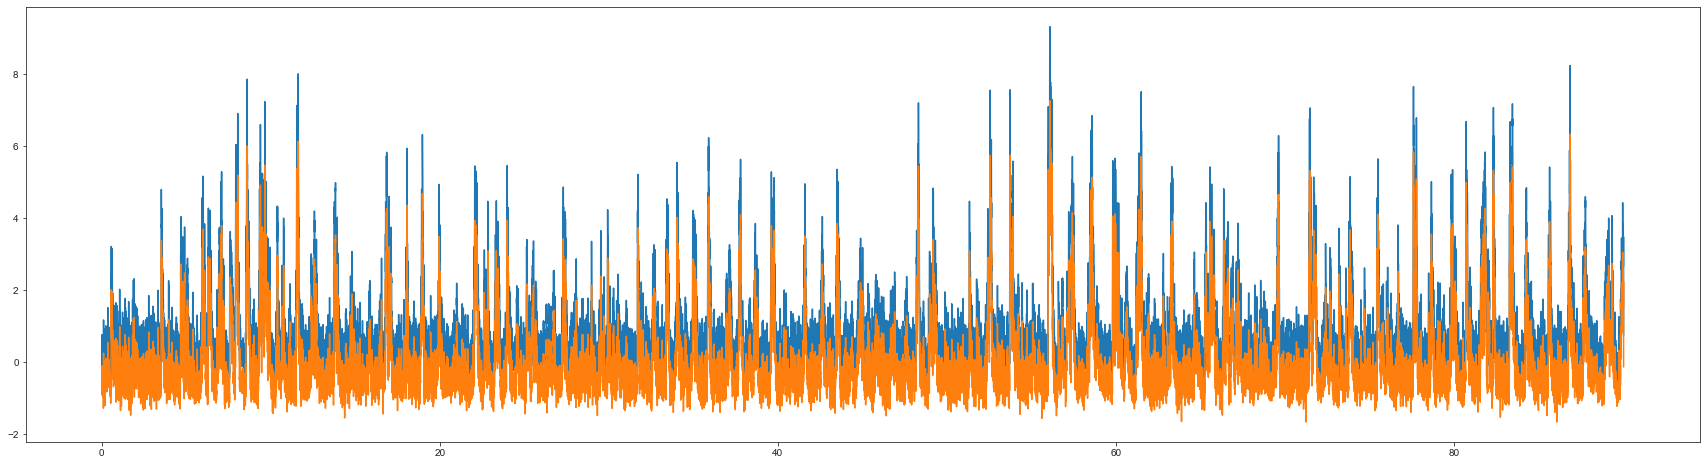

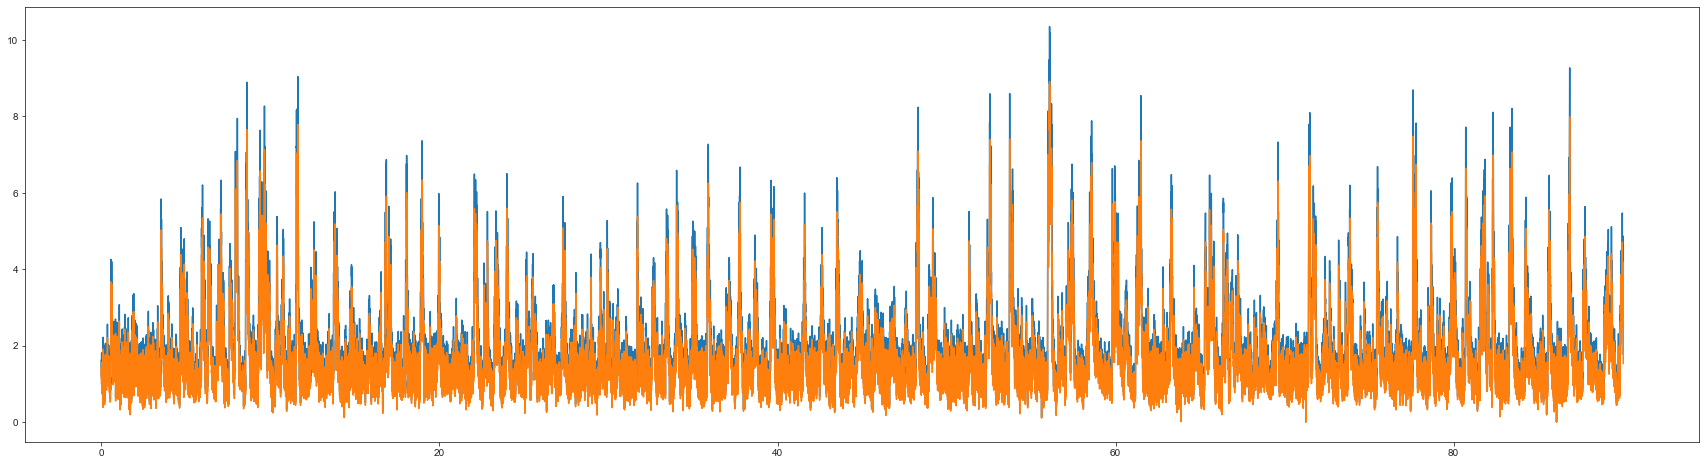

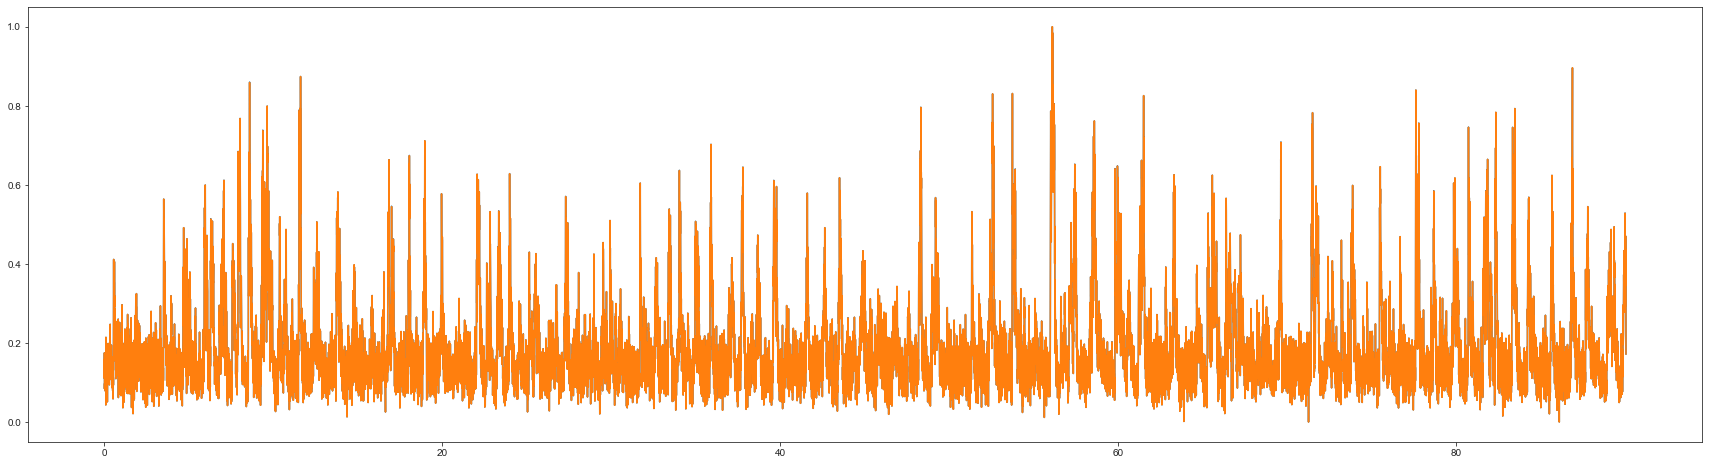

In [54]:
#create rectified dfof and dfof_z
dfof_upsamp_frame=pd.DataFrame(dfof_upsamp.T,index=behav_ser_dict_trunc['rt_ppl_ser'].index)
dfof_z_upsamp_frame=pd.DataFrame(dfof_z_upsamp.T,index=behav_ser_dict_trunc['rt_ppl_ser'].index)

dfof_rect_frame=dfof_upsamp_frame.copy()
dfof_z_rect_frame=dfof_z_upsamp_frame.copy()

dfof_upsamp_min=np.zeros(len(dfof_upsamp_frame.T),dtype=np.float16)
dfof_z_upsamp_min=np.zeros(len(dfof_z_upsamp_frame.T),dtype=np.float16)

for i in range(nNeurons):
    dfof_upsamp_min[i] = dfof_upsamp_frame[i].min()
    dfof_z_upsamp_min[i] = dfof_z_upsamp_frame[i].min()
    
for i in range(nNeurons):
    dfof_rect_frame[i] = dfof_rect_frame[i]-dfof_upsamp_min[i]
    dfof_z_rect_frame[i] = dfof_z_rect_frame[i]-dfof_z_upsamp_min[i]

#create normalized dfof and dfof_z
dfof_norm_frame=dfof_rect_frame.copy()
dfof_z_norm_frame=dfof_z_rect_frame.copy()

for i in range(nNeurons):
    dfof_norm_frame[i]=dfof_norm_frame[i]/dfof_norm_frame[i].max()
    dfof_z_norm_frame[i]=dfof_z_norm_frame[i]/dfof_z_norm_frame[i].max()
    
plt.figure(figsize=(30,8))
plt.plot(dfof_upsamp_frame.index/60,dfof_upsamp_frame[0])
plt.plot(dfof_z_upsamp_frame.index/60,dfof_z_upsamp_frame[0])

plt.figure(figsize=(30,8))
plt.plot(dfof_rect_frame.index/60,dfof_rect_frame[0])
plt.plot(dfof_z_rect_frame.index/60,dfof_z_rect_frame[0])

plt.figure(figsize=(30,8))
plt.plot(dfof_norm_frame.index/60,dfof_norm_frame[0])
plt.plot(dfof_z_norm_frame.index/60,dfof_z_norm_frame[0])

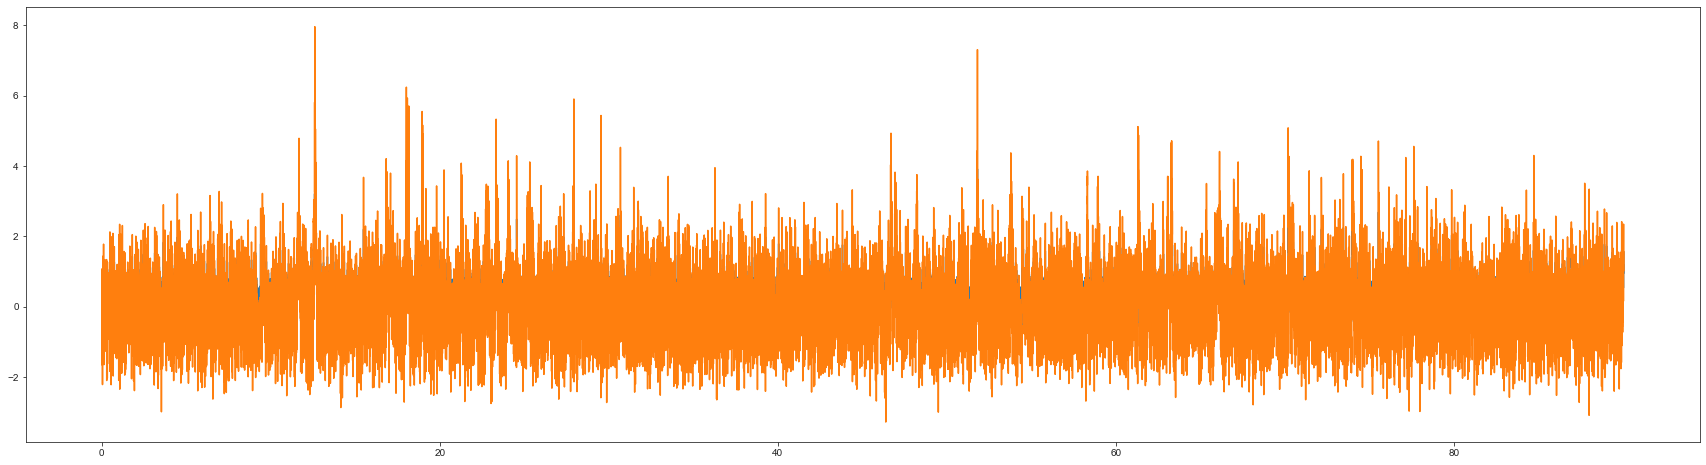

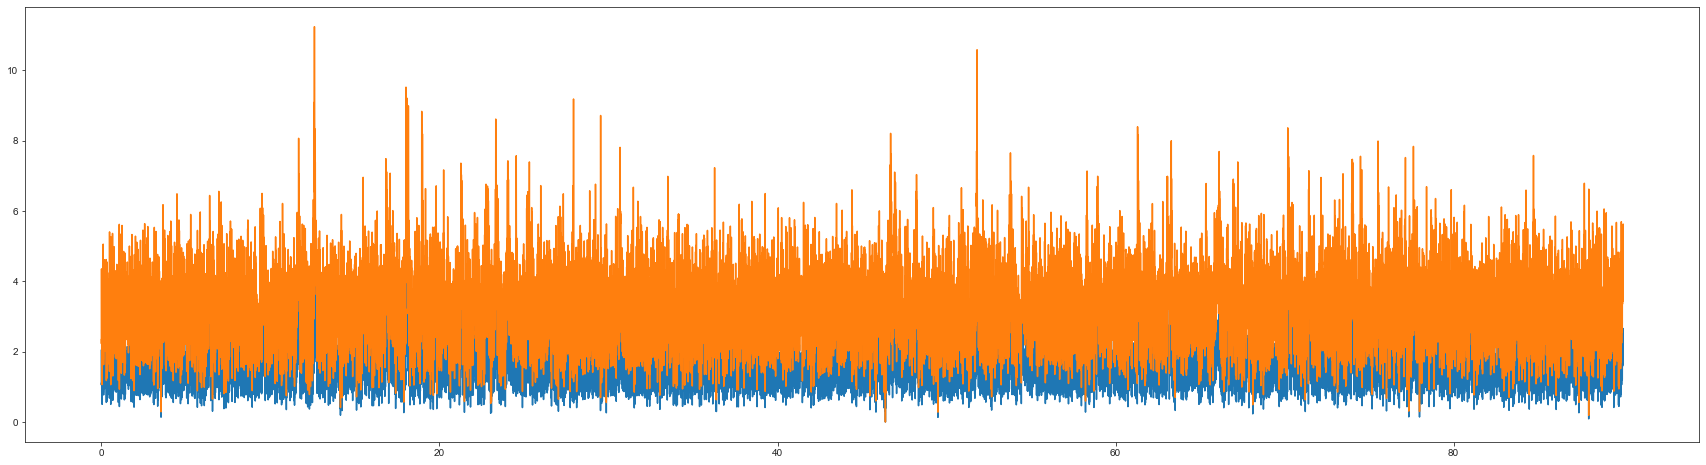

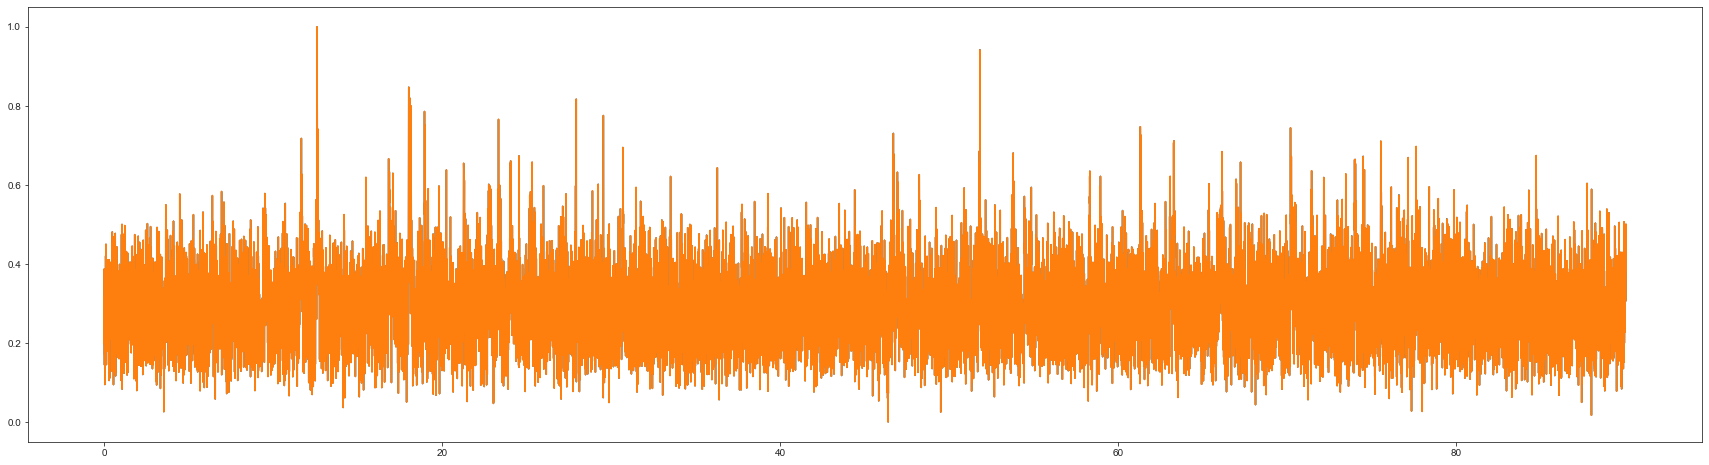

In [55]:
testCell=2004

plt.figure(figsize=(30,8))
plt.plot(dfof_upsamp_frame.index/60,dfof_upsamp_frame[isort_dfof_raw[testCell]])
plt.plot(dfof_z_upsamp_frame.index/60,dfof_z_upsamp_frame[isort_dfof_raw[testCell]])

plt.figure(figsize=(30,8))
plt.plot(dfof_rect_frame.index/60,dfof_rect_frame[isort_dfof_raw[testCell]])
plt.plot(dfof_z_rect_frame.index/60,dfof_z_rect_frame[isort_dfof_raw[testCell]])

plt.figure(figsize=(30,8))
plt.plot(dfof_norm_frame.index/60,dfof_norm_frame[isort_dfof_raw[testCell]])
plt.plot(dfof_z_norm_frame.index/60,dfof_z_norm_frame[isort_dfof_raw[testCell]])

In [56]:
#make dataFrames
behav_resamp_frame=pd.DataFrame(behav_ser_dict_trunc[behav_ser_keys[0]],index=behav_ser_dict_trunc['rt_ppl_ser'].index)
for i in range(len(behav_ser_keys)-1):
    behav_resamp_frame=pd.concat([behav_resamp_frame,behav_ser_dict_trunc[behav_ser_keys[i+1]]], axis=1)
behav_resamp_frame=behav_resamp_frame.set_axis(behav_ser_keys[:],axis=1)
    
#combine 2P and behav with indexed timestamps into data frame
behav_2P_comb_frame=pd.merge(behav_resamp_frame,dfof_upsamp_frame, left_index=True, right_index=True)
behav_2P_z_comb_frame=pd.merge(behav_resamp_frame,dfof_z_upsamp_frame, left_index=True, right_index=True)
behav_2P_rect_comb_frame=pd.merge(behav_resamp_frame,dfof_rect_frame, left_index=True, right_index=True)
behav_2P_z_rect_comb_frame=pd.merge(behav_resamp_frame,dfof_z_rect_frame, left_index=True, right_index=True)
behav_2P_norm_comb_frame=pd.merge(behav_resamp_frame,dfof_norm_frame, left_index=True, right_index=True)

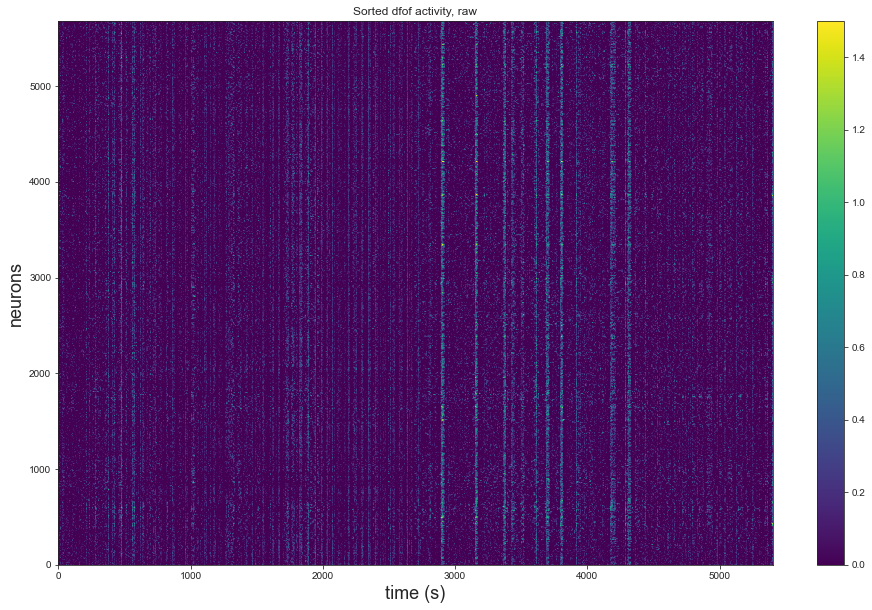

In [57]:
### view neuron sorting (Rastermap dF/F raw)
nT_plot = 18252; tStart = 0
plotslice = slice(tStart,tStart+nT_plot)
splot = dfof_z[isort_dfof_raw,plotslice]
plt.figure(figsize=(16,10))

ax=plt.imshow(splot[::-1], vmin=0,vmax=1.5,cmap='viridis',aspect='auto',extent=[0,splot.shape[1]/fs, 0,splot.shape[0]])
plt.xlabel('time (s)', fontsize=18)
plt.ylabel('neurons', fontsize=18)
plt.colorbar()
plt.title('Sorted dfof activity, raw')
plt.savefig(os.path.join(PlotDir,'rastermap_raw_sorted_dfof_{}.png'.format(fsuffix)))

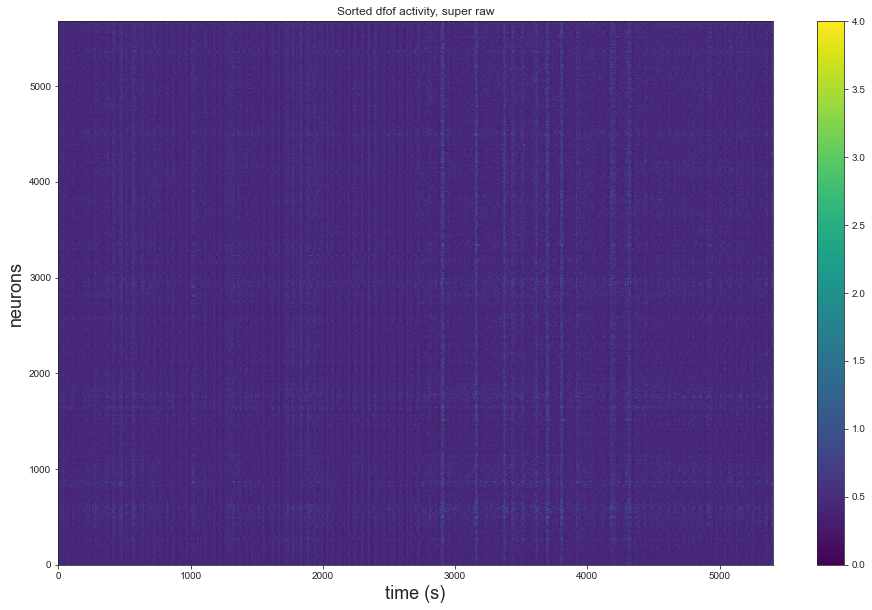

In [58]:
### view neuron sorting (Rastermap dF/F super raw)
nT_plot = 18252; tStart = 0
plotslice = slice(tStart,tStart+nT_plot)
splot = dfof[isort_dfof_raw,plotslice]
plt.figure(figsize=(16,10))

ax=plt.imshow(splot[::-1], vmin=0,vmax=4,cmap='viridis',aspect='auto',extent=[0,splot.shape[1]/fs, 0,splot.shape[0]])
plt.xlabel('time (s)', fontsize=18)
plt.ylabel('neurons', fontsize=18)
plt.colorbar()
plt.title('Sorted dfof activity, super raw')
plt.savefig(os.path.join(PlotDir,'rastermap_super_raw_sorted_dfof_c_{}.png'.format(fsuffix)))

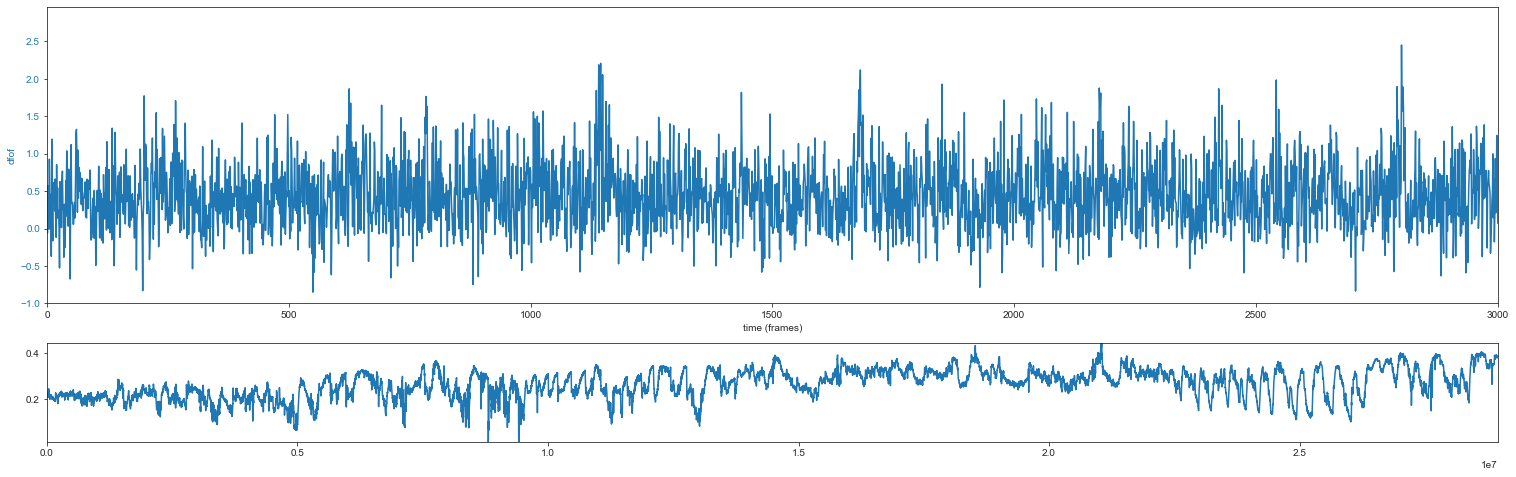

In [59]:
#plot raw dF/F etc

for i in range(2040,2041):

    iCell = i
    nT_plot = len(dfof[1]); tStart = 0
    plotslice = slice(tStart,tStart+nT_plot)

    fig, axes = plt.subplots(2,1,figsize=(26,8),gridspec_kw={'height_ratios':[3,1]})
    # axes[0].plot(dfof[iCell,plotslice])
    # axes[0].plot(events[iCell,plotslice])

    ax = axes[0]
    color = 'tab:blue'
    ax.set_xlabel('time (frames)')
    ax.set_ylabel('dfof', color=color)
    ax.plot(dfof[isort_dfof_raw[iCell],plotslice], color=color)
    # ax.plot(dfof_z[iCell,plotslice], color='k')
    # ax.plot(dfof_norm[iCell,plotslice], color='r')
    ax.tick_params(axis='y', labelcolor=color)
    ax.autoscale(tight=True)
    ax.set_xlim(0,3000)
    #ax.set_ylim(-2,150)

    #ax2 = axes[1]# ax.twinx()  # instantiate a second axes that shares the same x-axis

    #color = 'black'
    #ax2.set_ylabel('events', color=color)  # we already handled the x-label with ax1
    #ax2.vlines(np.where(events_binary[iCell,plotslice] == 1)[0],0,1, color=color,lw=0.5)
    #ax2.tick_params(axis='y', labelcolor=color)
    #ax.autoscale(tight=True)
    #need to align x axis of ax2 to ax1

    ax2=axes[1]
    ax2.set_ylim(0.5,1.2)
    ax2.plot(behav_dict_aligned['rt_ppl'], color=color)
    ax2.autoscale(tight=True)


    plt.savefig(save_folder +'\dfof_raw_ppl_aligned_isort_dfof_raw_'+str(iCell)+'.tif',dpi=300,format='tif')

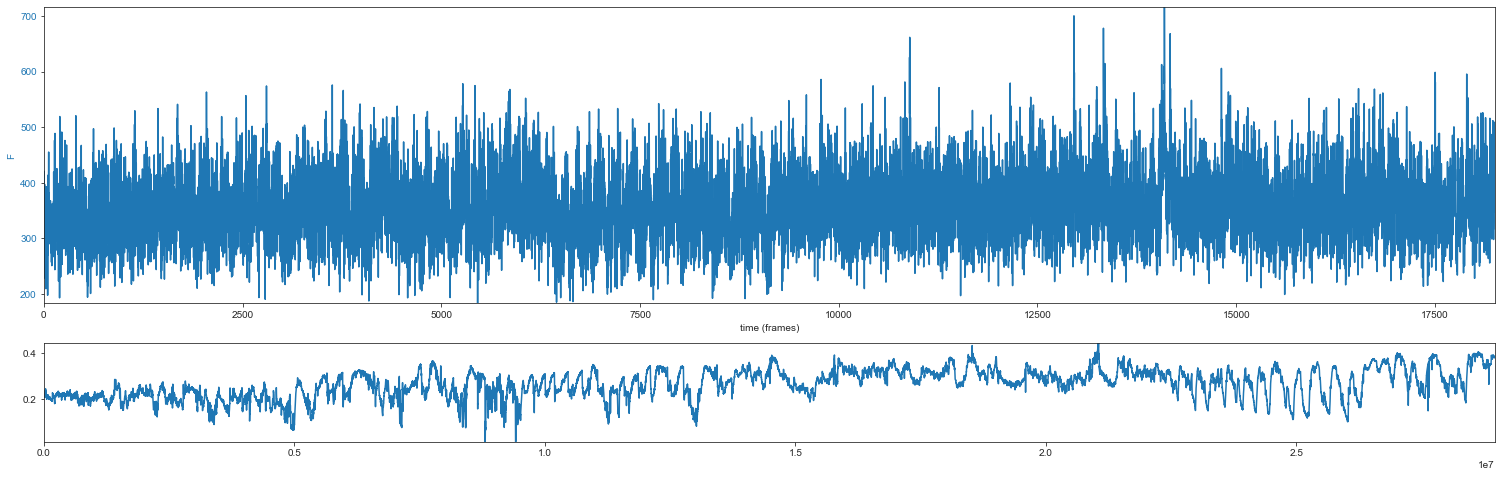

In [60]:
#plot raw F etc

for i in range(2040,2041):

    iCell = i
    nT_plot = len(dfof[1]); tStart = 0
    plotslice = slice(tStart,tStart+nT_plot)

    fig, axes = plt.subplots(2,1,figsize=(26,8),gridspec_kw={'height_ratios':[3,1]})
    # axes[0].plot(dfof[iCell,plotslice])
    # axes[0].plot(events[iCell,plotslice])

    ax = axes[0]
    color = 'tab:blue'
    ax.set_xlabel('time (frames)')
    ax.set_ylabel('F', color=color)
    ax.plot(fluorescence[isort_dfof_raw[iCell],plotslice], color=color)
    # ax.plot(dfof_z[iCell,plotslice], color='k')
    # ax.plot(dfof_norm[iCell,plotslice], color='r')
    ax.tick_params(axis='y', labelcolor=color)
    ax.autoscale(tight=True)
    #ax.set_xlim(0,500)
    #ax.set_ylim(-2,150)

    #ax2 = axes[1]# ax.twinx()  # instantiate a second axes that shares the same x-axis

    #color = 'black'
    #ax2.set_ylabel('events', color=color)  # we already handled the x-label with ax1
    #ax2.vlines(np.where(events_binary[iCell,plotslice] == 1)[0],0,1, color=color,lw=0.5)
    #ax2.tick_params(axis='y', labelcolor=color)
    #ax.autoscale(tight=True)
    #need to align x axis of ax2 to ax1

    ax2=axes[1]
    ax2.set_ylim(0.5,1.2)
    ax2.plot(behav_dict_aligned['rt_ppl'], color=color)
    ax2.autoscale(tight=True)


    plt.savefig(save_folder +'\F_raw_ppl_aligned_isort_F_raw_'+str(iCell)+'.tif',dpi=300,format='tif')

In [61]:
#save standard frames scaled with multiple BSOID RAWs and keypoint MOSEQ, 15th percentile dfof baseline

import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)
save_standard_frames_scaled_multiple_BSOiD_RAW_kMOSEQ_15_perc_filename_npy=PlotDir+'\\standard_frames_scaled_multiple_BSOiD_RAW_kMOSEQ_15_perc_'+fsuffix+'_'+timestr+'.npy'
print(save_standard_frames_scaled_multiple_BSOiD_RAW_kMOSEQ_15_perc_filename_npy)

save_standard_frames_scaled_multiple_BSOiD_RAW_kMOSEQ_15_perc_dict={'behav_resamp_frame':behav_resamp_frame,'behav_resamp_frame_scaled':behav_resamp_frame_scaled,'behav_corr_frame':behav_corr_frame,'dfof_upsamp_frame':dfof_upsamp_frame,'bsoid_frame':bsoid_frame,'roi_info_frame':roi_info_frame,'areas':areas,'iscell':iscell,'ops':ops,\
                          'behav_t':behav_t,'ppl_t':ppl_t,'movie_t':movie_t,'meso_t':meso_t,'dfof_upsamp_frame.index':dfof_upsamp_frame.index,'session_masks':session_masks,'iscell_masks':iscell_masks,'area_num':area_num,'outlines_flat':outlines_flat,\
                          'nROIs':nROIs,'stat':stat,'fsuffix':fsuffix,'PlotDir':PlotDir,'y_pred':y_pred,'isort_dfof':isort_dfof,'isort':isort,'plotslice':plotslice,'isort_dfof_kmeans':isort_dfof_kmeans,'nClusters':nClusters,\
                          'min_range':min_range,'max_range':max_range,'areas_rastermap_density':areas_rastermap_density,'raster_cell_count':raster_cell_count,'raster_cell_densities':raster_cell_densities, \
                          'session_masks_rastermap_density':session_masks_rastermap_density,'im_restrict_masked_rastermap_density':im_restrict_masked_rastermap_density,'raster_mean_traces':raster_mean_traces, \
                          'kernel_size':kernel_size,'kernel':kernel,'joint_restricted_frame':joint_restricted_frame,'joint_raw_restricted_frame': \
                          joint_raw_restricted_frame,'joint_motifs_raw_frame':joint_motifs_raw_frame,'joint_motifs_frame':joint_motifs_frame,'raster_mean_traces_frame':raster_mean_traces_frame,'raster_mean_traces_upsamp_frame': \
                          raster_mean_traces_upsamp_frame,'rastermap_upsamp_frame':rastermap_upsamp_frame,'res_int':res_int,'iscell_masks_cell':iscell_masks_cell,\
                          'nClust_cell_count':nClust_cell_count,'plot_time':plot_time,'raster_mean_traces_convolved':raster_mean_traces_convolved, 'PlotDir':PlotDir,'nNeurons':nNeurons,'cell_count':cell_count,'behav_scaled_2P_comb':behav_scaled_2P_comb,'behav_scaled_2P_comb_frame':behav_scaled_2P_comb_frame,\
                          'df':df,'kMOSEQ_frame':kMOSEQ_frame,'kMOSEQ_motifs':kMOSEQ_motifs,'kMOSEQ_ser':kMOSEQ_ser,'temp':temp,'kMOSEQ_hot':kMOSEQ_hot,'kMOSEQ_time':kMOSEQ_time,'time_sec':time_sec,'time_min':time_min,\
                          'time_sec_behav':time_sec_behav,'time_min_behav':time_min_behav,'temp_b':temp_b,'behav_2P_comb_frame':behav_2P_comb_frame,'bsoid_array_old':bsoid_array_old}

save_standard_frames_scaled_multiple_BSOiD_RAW_kMOSEQ_15_perc_arr=np.array(save_standard_frames_scaled_multiple_BSOiD_RAW_kMOSEQ_15_perc_dict)
np.save(save_standard_frames_scaled_multiple_BSOiD_RAW_kMOSEQ_15_perc_filename_npy,save_standard_frames_scaled_multiple_BSOiD_RAW_kMOSEQ_15_perc_arr)

20230705-172640
G:\uobrainflex_analysis_2022\A1V1M2\standard_frames_plus_kMOSEQ_15_perc\standard_frames_scaled_multiple_BSOiD_RAW_kMOSEQ_15_perc_3056_200924_E235_1_00003_00001_20230705-172640.npy


In [ ]:
#save standard frames scaled with BSOID RAW and keypoint MOSEQ, 15th percentile dfof baseline

import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)
save_standard_frames_scaled_BSOiD_RAW_kMOSEQ_15_perc_filename_npy=PlotDir+'\\standard_frames_scaled_BSOiD_RAW_kMOSEQ_15_perc_'+fsuffix+'_'+timestr+'.npy'
print(save_standard_frames_scaled_BSOiD_RAW_kMOSEQ_15_perc_filename_npy)

save_standard_frames_scaled_BSOiD_RAW_kMOSEQ_15_perc_dict={'behav_resamp_frame':behav_resamp_frame,'behav_resamp_frame_scaled':behav_resamp_frame_scaled,'behav_corr_frame':behav_corr_frame,'dfof_upsamp_frame':dfof_upsamp_frame,'bsoid_frame':bsoid_frame,'roi_info_frame':roi_info_frame,'areas':areas,'iscell':iscell,'ops':ops,\
                          'behav_t':behav_t,'ppl_t':ppl_t,'movie_t':movie_t,'meso_t':meso_t,'dfof_upsamp_frame.index':dfof_upsamp_frame.index,'session_masks':session_masks,'iscell_masks':iscell_masks,'area_num':area_num,'outlines_flat':outlines_flat,\
                          'nROIs':nROIs,'stat':stat,'fsuffix':fsuffix,'PlotDir':PlotDir,'y_pred':y_pred,'isort_dfof':isort_dfof,'isort':isort,'plotslice':plotslice,'isort_dfof_kmeans':isort_dfof_kmeans,'nClusters':nClusters,\
                          'min_range':min_range,'max_range':max_range,'areas_rastermap_density':areas_rastermap_density,'raster_cell_count':raster_cell_count,'raster_cell_densities':raster_cell_densities, \
                          'session_masks_rastermap_density':session_masks_rastermap_density,'im_restrict_masked_rastermap_density':im_restrict_masked_rastermap_density,'raster_mean_traces':raster_mean_traces, \
                          'kernel_size':kernel_size,'kernel':kernel,'joint_restricted_frame':joint_restricted_frame,'joint_raw_restricted_frame': \
                          joint_raw_restricted_frame,'joint_motifs_raw_frame':joint_motifs_raw_frame,'joint_motifs_frame':joint_motifs_frame,'raster_mean_traces_frame':raster_mean_traces_frame,'raster_mean_traces_upsamp_frame': \
                          raster_mean_traces_upsamp_frame,'rastermap_upsamp_frame':rastermap_upsamp_frame,'res_int':res_int,'iscell_masks_cell':iscell_masks_cell,\
                          'nClust_cell_count':nClust_cell_count,'plot_time':plot_time,'raster_mean_traces_convolved':raster_mean_traces_convolved, 'PlotDir':PlotDir,'nNeurons':nNeurons,'cell_count':cell_count,'behav_scaled_2P_comb':behav_scaled_2P_comb,'behav_scaled_2P_comb_frame':behav_scaled_2P_comb_frame,\
                          'df':df,'kMOSEQ_frame':kMOSEQ_frame,'kMOSEQ_motifs':kMOSEQ_motifs,'kMOSEQ_ser':kMOSEQ_ser,'temp':temp,'kMOSEQ_hot':kMOSEQ_hot,'kMOSEQ_time':kMOSEQ_time,'time_sec':time_sec,'time_min':time_min,\
                          'time_sec_behav':time_sec_behav,'time_min_behav':time_min_behav,'temp_b':temp_b,'behav_2P_comb_frame':behav_2P_comb_frame,'bsoid_array_old':bsoid_array_old}

save_standard_frames_scaled_BSOiD_RAW_kMOSEQ_15_perc_arr=np.array(save_standard_frames_scaled_BSOiD_RAW_kMOSEQ_15_perc_dict)
np.save(save_standard_frames_scaled_BSOiD_RAW_kMOSEQ_15_perc_filename_npy,save_standard_frames_scaled_BSOiD_RAW_kMOSEQ_15_perc_arr)